<a href="https://colab.research.google.com/github/indiee27/IPMI-Portfolio/blob/main/IPMI20_21_Brain_Tissue_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**IPMI20-21 Lab session**

---


#**Brain Tissue Segmentation**
The goal of the workshop is to segment 2D brain images using a Gaussian Mixture Model, solved using the Expectation-Maximisation algorithm. The code for K-means segmentation is included for comparison. Your task is to use the code below to generate segmentations on the 4 different input images, and use different options when running the segmentation.<br>  
###Exercise
**You should use these data to produce brief report that includes tables and/or figures that summarises the different results.**<br>
Please share your report with one of the teaching team for some feedback prior to leaving the session.

---


Finally, there is an exercise to load a 3D Nifti file, slice into 2D images and then segment using one of the pipelines tested previously.

#Set up
Start by importing numpy, scipy, nibabel and the Python Image Library, along with matplotlib and seaborn for plotting purposes.

In [ ]:
from collections import defaultdict
from IPython.display import display, Image # to display images
import matplotlib.pyplot as plt
import nibabel as nib # for reading Nifti files
import numpy as np
import PIL as pl
import os
import scipy as sp
import seaborn as sns
from sklearn import cluster # for running K-means
import sys

##Define functions
Here we will define a few different functions to make running the pipelines more straightforward.

###Read images and convert to arrays

In [ ]:
def read_file(filename):
    imagefile = pl.Image.open(filename)
    image_array = np.array(imagefile.getdata(), np.uint8).reshape(imagefile.size[1], imagefile.size[0])
    return image_array.astype('float32')

###Convert array to image

In [ ]:
def array_to_image(array):
    minimal_value = np.min(array)
    maximal_value = np.max(array)
    if minimal_value < 0 or maximal_value > 255:
        array = 255*(array-minimal_value)/(maximal_value-minimal_value)
    array_uint8 = array.astype('uint8')
    return pl.Image.fromarray(array_uint8, 'L') #saves as 8-bit pixels

###Save array as image file

In [ ]:
def save_file(array,filename):
    imagefile = array_to_image(array)
    imagefile.save(filename)

###Markov Random Field
Function to apply a 2D MRF, hence 4 neighbouring pixels (top, bottom, left, right).

In [ ]:
def Umrf(pik, k):
    G = np.ones((4, 4)) - np.diag([1, 1, 1, 1])
    Umrf = np.ndarray([np.size(pik, 0), np.size(pik, 1)])
    for indexX in range(0, np.size(pik, 0)):
        for indexY in range(0, np.size(pik, 1)):
            UmrfAtIndex = 0
            for j in range(0, np.size(pik, 2)):
                Umrfj=0
                # Umrf top
                if (indexY + 1) < np.size(pik, 1):
                    Umrfj += pik[indexX, indexY + 1, j]
                # Umrf bottom
                if (indexY - 1) > -1:
                    Umrfj += pik[indexX, indexY - 1, j]
                # Umrf right
                if (indexX + 1) < np.size(pik, 0):
                    Umrfj += pik[indexX + 1, indexY, j]
                # Umrf left
                if (indexX - 1) > -1:
                    Umrfj += pik[indexX - 1, indexY, j]
                UmrfAtIndex += Umrfj * G[k, j]
            Umrf[indexX,indexY]=UmrfAtIndex;
    return Umrf

##Get data
###Clone from Github

In [ ]:
!git clone https://github.com/james-cole/IPMI-teaching.git
fileLocation = "./IPMI-teaching/"
!ls -lh IPMI-teaching/

Cloning into 'IPMI-teaching'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
total 6.9M
-rw-r--r-- 1 root root  27K Feb 17 16:34 brain_bias.png
-rw-r--r-- 1 root root  31K Feb 17 16:34 brain_noise.png
-rw-r--r-- 1 root root  22K Feb 17 16:34 brain.png
-rw-r--r-- 1 root root  13K Feb 17 16:34 CSF_prior.png
-rw-r--r-- 1 root root  25K Feb 17 16:34 GM_prior.png
-rw-r--r-- 1 root root 6.2K Feb 17 16:34 NonBrain_prior.png
-rw-r--r-- 1 root root   90 Feb 17 16:34 README.md
-rw-r--r-- 1 root root 6.7M Feb 17 16:34 T1w_standard.nii.gz
-rw-r--r-- 1 root root  35K Feb 17 16:34 verynoisy.png
-rw-r--r-- 1 root root  25K Feb 17 16:34 WM_prior.png


##Display brain slice images

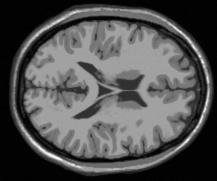

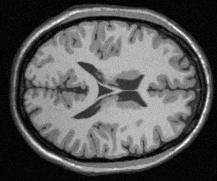

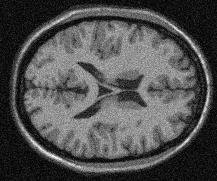

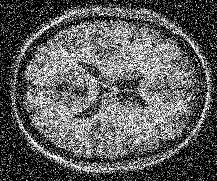

In [ ]:
display(Image(fileLocation+'brain.png'))
display(Image(fileLocation+'brain_bias.png'))
display(Image(fileLocation+'brain_noise.png'))
display(Image(fileLocation+'verynoisy.png'))

##Load data
This reads in a PNG file and converts it to an array.

In [ ]:
print("Loading data")

# Brain slices
brainData = read_file(fileLocation+'brain.png')
noiseData = read_file(fileLocation+'brain_noise.png')
verynoisyData = read_file(fileLocation+'verynoisy.png')
biasData = read_file(fileLocation+'brain_bias.png')

Loading data


####Get image dimensions

In [ ]:
brainData.shape

(181, 217)

##Plot histograms of the brain images
Try changing which images are displayed and compare the histograms

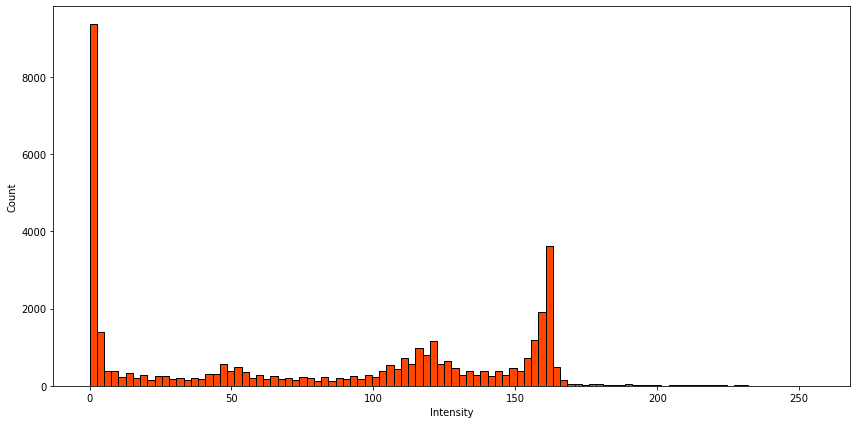

In [ ]:
imgData = brainData
plt.figure(figsize=(12,6))
plt.hist(np.concatenate(imgData), bins=100, facecolor='orangered', edgecolor='black')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.tight_layout()

##Density plot of brain slice intensities

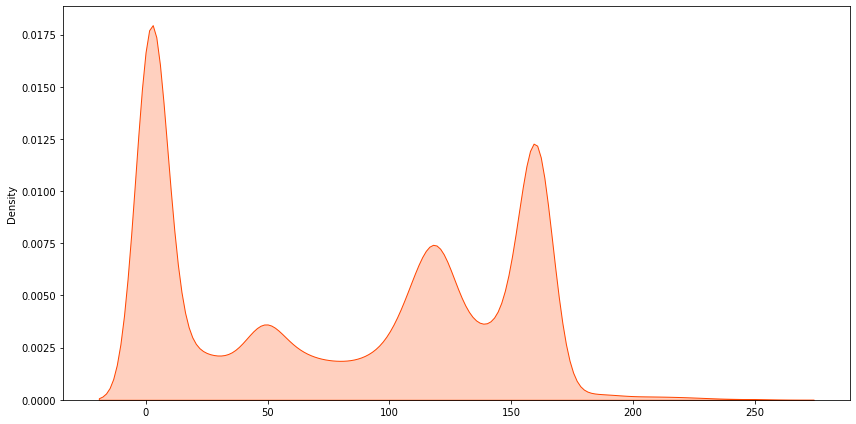

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(np.concatenate(brainData), color = 'orangered', shade =True, bw_method=0.1)
plt.tight_layout()

#K-means for brains
Here we try using the sci-kit learn implementation of k-means to segment a brain image. **Try changing the number of clusters (k) and see how this impacts the results.**

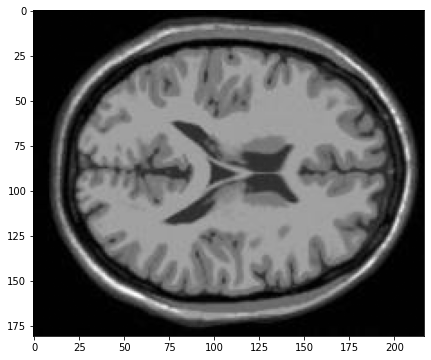

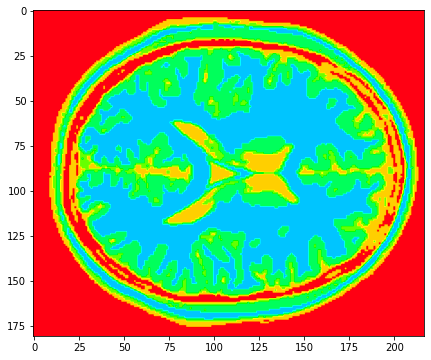

In [ ]:
imgData = brainData
# set number of clusters K
k = 5
np.random.seed(0)

# Reshape to a (n_sample, n_feature) array
X = imgData.reshape((-1, 1))

# define and run K-means
k_means = cluster.KMeans(n_clusters=k, n_init=4)
k_means.fit(X)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

# create an array from labels and values
imgData_seg = np.choose(labels, values)
imgData_seg.shape = imgData.shape

vmin = imgData.min()
vmax = imgData.max()

# original image
plt.figure(1, figsize=(7,6))
plt.imshow(imgData, cmap='gray', vmin=vmin, vmax=256)

# segmented image
plt.figure(2, figsize=(7, 6))
plt.imshow(imgData_seg, cmap='gist_rainbow', vmin=vmin, vmax=vmax)

##Plot the different classes
While it's useful to view the predicted classes together, it can also help to see them plotted separately. Do the maps resemble known brain tissue distributions?

Number of clusters K = 5


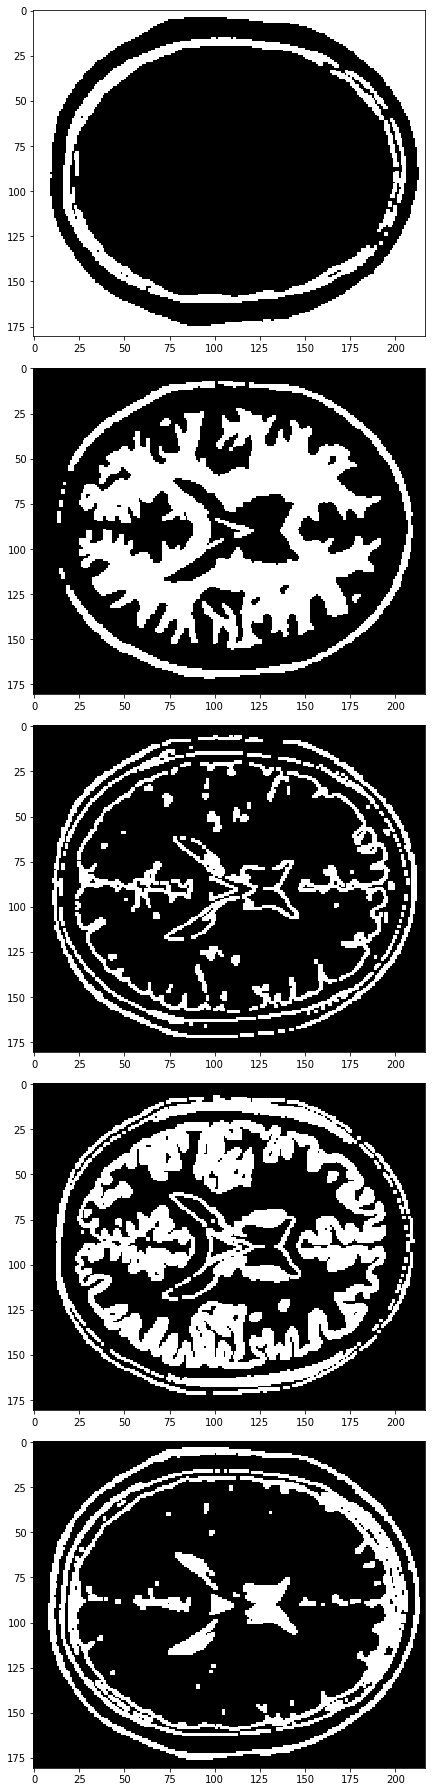

In [ ]:
fig,axes = plt.subplots(nrows=k,ncols=1, figsize=(k*5,k*5))
axes = axes.flatten()
seg = defaultdict()
for i in range(k):
  seg[i] = np.ma.masked_where(imgData_seg == values[i], imgData_seg)
  axes[i].imshow(seg[i], cmap='binary', vmin=0, vmax=1)
print("Number of clusters K = "+ str(k))
plt.tight_layout()

#Expectation-maximisation for GMM segmentation
A potentially more powerful approach is to fit a Gaussian Mixture Model (GMM) instead, that takes into the parameters of the latent distributions in the data. 
##Select data and set parameters
Choose which image to use as input (normal brain, noisy, very nosiy or bias).<br>
Set the number of classes, allocate space for arrays and for the priors, the maximum number of iterations and convergence tolerance level.<br>
You can try varying the maximum number of iterations (*maxIterations*) or tolerance level and see how this affects results.

In [ ]:
# Select input data
imgData = brainData

# Parameters
didNotConverge = 1
iteration = 0
maxIterations = 20
numClass = 3
beta = 2
logLik = int(-10e8)
oldLogLik = int(-10e8)
tolerance = 200

# Initialise mean and variances
np.random.seed(37) # set seed for reproducibility
mean = np.random.rand(numClass,1)*256;
var = (np.random.rand(numClass,1)*10)+200;

# Allocate space for the posteriors
classProb = np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
classProbSum = np.ndarray([np.size(imgData,0),np.size(imgData,1)])

# Define array for MRF that matches image dimensions
MRF=np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
MRF[:,:,:]=1

##Run Iterative EM process
Try running with and without the MRF, see how this changes the results, particularly when varying the input file (i.e., brainData vs. noiseData). To do this, comment out the appropriate line in the Expectation code block.

*Remember to reset the parameters above, each time you run the EM algorithm.*



In [ ]:
# Iterative process
while didNotConverge:
    iteration=iteration+1

    # Expectation
    classProbSum[:, :] = 0;
    for classIndex in range(0, numClass):
        gaussPdf = (1/np.sqrt(var[classIndex]*2*np.pi))*np.exp(-0.5* (imgData-mean[classIndex])**2/var[classIndex])
        classProb[:, :, classIndex] = (gaussPdf + 0.0000001) * MRF[:,:,classIndex] # comment out this line to remove the MRF term
        #classProb[:, :, classIndex] = (gaussPdf + 0.0000001) # include this line to remove the MRF term
        classProbSum[:, :] = classProbSum[:, :] + classProb[:, :, classIndex]
        
    # Normalise posterior
    for classIndex in range(0, numClass):
        classProb[:, :, classIndex] = classProb[:, :, classIndex] / classProbSum[:, :]

    # Maximization
    print("Iteration #" + str(iteration))
    for classIndex in range(0, numClass):
        pik = classProb[:, :, classIndex]
        mean[classIndex] = np.sum(pik*imgData) / np.sum(pik)
        var[classIndex] = np.sum(pik*((imgData - mean[classIndex])**2)) / np.sum(pik)
        MRF[:,:,classIndex] = np.exp(-beta * Umrf(classProb,classIndex))
        print("Class index " + str(classIndex) + ": mean = " + str(mean[classIndex]) + ", variance = " + str(var[classIndex]))

    # Calculate log likelihood
    oldLogLik = logLik
    logLik = np.sum(np.log(classProbSum))
    diffLogLik = oldLogLik - logLik
    print("Loglikelihood change = " + str(diffLogLik))

    if abs(diffLogLik)<=tolerance:
      didNotConverge=0
      print("Converged after " + str(iteration) + " iterations")

    if iteration>=maxIterations:
        didNotConverge=0
        print("Reached "+ str(maxIterations) + " iterations (the maximum) and did not coverge")

Iteration #1
Class index 0: mean = [200.22142599], variance = [1250.25753644]
Class index 1: mean = [136.76368556], variance = [560.19162953]
Class index 2: mean = [19.45530065], variance = [621.6634633]
Loglikelihood change = -999746908.2837449
Iteration #2
Class index 0: mean = [197.49526479], variance = [694.07352758]
Class index 1: mean = [136.16587302], variance = [589.92318026]
Class index 2: mean = [18.57236909], variance = [572.58575144]
Loglikelihood change = -56759.45652906131
Iteration #3
Class index 0: mean = [200.56492057], variance = [557.90172071]
Class index 1: mean = [135.70856461], variance = [608.95251105]
Class index 2: mean = [18.04909718], variance = [545.13370874]
Loglikelihood change = -1338.9938501784927
Iteration #4
Class index 0: mean = [200.12687055], variance = [577.73939174]
Class index 1: mean = [135.34613501], variance = [630.86049831]
Class index 2: mean = [17.61046192], variance = [523.08389159]
Loglikelihood change = -458.3012891256076
Iteration #5
Cl

###Save segmented images as separate PNG files
Uncomment the cell below to save to Google drive

In [ ]:
# for classIndex in range(0, numClass):
#     print("Saving "+"seg"+str(classIndex)+".png")
#     save_file(classProb[ : ,: ,classIndex] * 255, "seg"+str(classIndex)+".png")

Saving seg0.png
Saving seg1.png
Saving seg2.png


###Display images
Take a look at the results. How do they compare to the K-means output? What's the impact of varying K? What difference does the MRF constraint make?

Class number 0


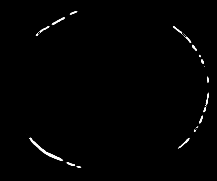

Class number 1


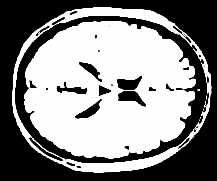

Class number 2


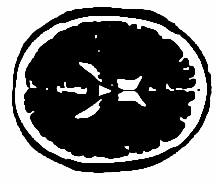

In [ ]:
for seg in range(numClass):
    print('Class number '+str(seg))
    display(Image('seg'+str(seg)+'.png'))

###Download images
To get the results you can download the image PNG files to your local machine. Uncomment the code cell below:

In [ ]:
# from google.colab import files
# files.download('seg0.png')

##Add anatomical priors to the algorithm
The priors provide spatial probabilities about the likely tissue class in each pixel.

###Display image priors

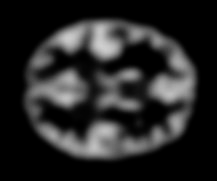

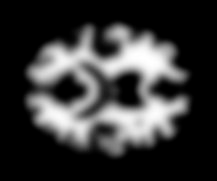

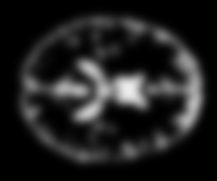

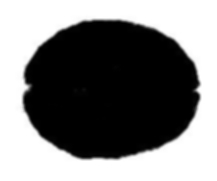

In [ ]:
display(Image(fileLocation+'GM_prior.png'))
display(Image(fileLocation+'WM_prior.png'))
display(Image(fileLocation+'CSF_prior.png'))
display(Image(fileLocation+'NonBrain_prior.png'))

Read in and convert to arrays

In [ ]:
print("Loading data")
GM_Prior = read_file(fileLocation+'GM_prior.png')
WM_Prior = read_file(fileLocation+'WM_prior.png')
CSF_Prior = read_file(fileLocation+'CSF_prior.png')
Other_Prior = read_file(fileLocation+'NonBrain_prior.png')

Loading data


###Edit model parameters to incorporate priors
Try changing the input data to see how this impacts the results. Note that the number of classes (K) must be the same as the number of different prior maps, so here K must = 4. 

In [ ]:
# Select input data
imgData = brainData

# Parameters
didNotConverge = 1
iteration = 0
maxIterations = 20
numClass = 4
beta = 2
logLik = int(-10e8)
oldLogLik = int(-10e8)
tolerance = 200

# Initialise mean and variances
mean = np.random.rand(numClass,1)*256;
var = (np.random.rand(numClass,1)*10)+200;

# Allocate space for the posteriors
classProb = np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
classProbSum = np.ndarray([np.size(imgData,0),np.size(imgData,1)])

# Allocate space for the priors
classPrior=np.ndarray([np.size(imgData,0),np.size(imgData,1),4])
classPrior[:, :, 0] = GM_Prior/255
classPrior[:, :, 1] = WM_Prior/255
classPrior[:, :, 2] = CSF_Prior/255
classPrior[:, :, 3] = Other_Prior/255

for classIndex in range(0, numClass):
    pik = classPrior[:, :, classIndex]
    mean[classIndex] = np.sum(pik * imgData) / np.sum(pik)
    var[classIndex] = np.sum(pik * ((imgData - mean[classIndex]) ** 2)) / np.sum(pik)

# Define MRF array to match image dimensions
MRF=np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
MRF[:,:,:]=1

###Re-run EM process
This time the class probabilities are multiplied by the probability value from the anatomical prior at each pixel.

In [ ]:
# Conditional to stop process if numClass != 4
if numClass != 4:
    print('no')
    sys.exit("numClass must == 4")

# Iterative process
while didNotConverge:
    iteration=iteration+1

    # Expectation
    classProbSum[:, :] = 0;
    for classIndex in range(0, numClass):
        gaussPdf = (1/np.sqrt(var[classIndex]*2*np.pi))*np.exp(-0.5* (imgData-mean[classIndex])**2/var[classIndex])
        classProb[:, :, classIndex] = (gaussPdf+0.0000001) * classPrior[:, :, classIndex] * MRF[:,:,classIndex]
        classProbSum[:, :] = classProbSum[:, :]+classProb[:, :, classIndex]

    # Normalise posterior
    for classIndex in range(0, numClass):
        classProb[:, :, classIndex] = classProb[:, :, classIndex] /classProbSum[:, :]

    # Maximization
    print("Iteration #"+str(iteration))
    for classIndex in range(0, numClass):
        pik = classProb[:, :, classIndex]
        mean[classIndex] = np.sum(pik*imgData) / np.sum(pik)
        var[classIndex] = np.sum(pik*((imgData - mean[classIndex])**2)) / np.sum(pik)
        MRF[:,:,classIndex] = np.exp(-beta * Umrf(classProb,classIndex))
        print("Class index "+ str(classIndex) + ": mean = "+str(mean[classIndex]) + ", variance = " + str(var[classIndex]))

    # Calculate log likelihood
    oldLogLik = logLik
    logLik = np.sum(np.log(classProbSum))
    diffLogLik = oldLogLik - logLik
    print("Loglikelihood change = " + str(diffLogLik))

    if abs(diffLogLik)<=tolerance:
      didNotConverge=0
      print("Converged after " + str(iteration) + " iterations")

    if iteration>=maxIterations:
        didNotConverge=0
        print("Reached "+ str(maxIterations) + " iterations (the maximum) and did not coverge")

Iteration #1
Class index 0: mean = [119.08280602], variance = [549.04923411]
Class index 1: mean = [152.38237367], variance = [211.54946565]
Class index 2: mean = [92.38972156], variance = [1783.77090033]
Class index 3: mean = [31.84920567], variance = [2321.1404959]
Loglikelihood change = -999803440.1502862
Iteration #2
Class index 0: mean = [117.12908121], variance = [213.21799132]
Class index 1: mean = [155.31266215], variance = [104.23148353]
Class index 2: mean = [74.23591897], variance = [882.59985544]
Class index 3: mean = [34.21546261], variance = [2530.54007746]
Loglikelihood change = 47101.72113573656
Iteration #3
Class index 0: mean = [117.72201553], variance = [179.3609384]
Class index 1: mean = [156.30468065], variance = [75.10943858]
Class index 2: mean = [70.34792359], variance = [572.3106755]
Class index 3: mean = [34.6323791], variance = [2581.61128375]
Loglikelihood change = -33300.281819237105
Iteration #4
Class index 0: mean = [118.41758083], variance = [167.5741735

Uncomment the cell below to save the files to Google drive

In [ ]:
# for classIndex in range(0, numClass):
#     print("Saving "+"prior_seg"+str(classIndex)+".png")
#     save_file(classProb[ : ,: ,classIndex] * 255, "prior_seg"+str(classIndex)+".png")

Saving prior_seg0.png
Saving prior_seg1.png
Saving prior_seg2.png
Saving prior_seg3.png


Display the images. How do they compare to the previous versions without anatomical priors?

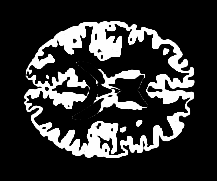

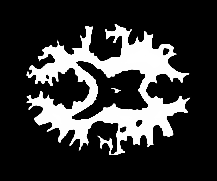

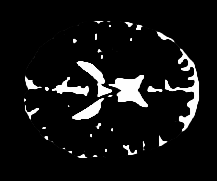

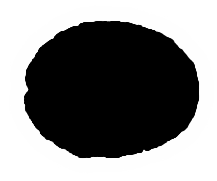

In [ ]:
display(Image('prior_seg0.png'))
display(Image('prior_seg1.png'))
display(Image('prior_seg2.png'))
display(Image('prior_seg3.png'))

---
#Working with Nifti files
The following is a brief tutorial on how to load, view and manipulate Nifti (.nii) files in Python. This example takes a slice and run it through the EM procedure using GMMs to segment brain tissue as above. For this example to work well, you need to select an axial slice similar to the anatomical priors.

##Define function to read in 3D brain image
Uses nibabel library to read nifti files

In [ ]:
t1_nii = fileLocation+'T1w_standard.nii.gz'
print(t1_nii)
img = nib.load(t1_nii)
img_array = img.get_fdata() # convert from nifti object to array

./IPMI-teaching/T1w_standard.nii.gz


##Plot image slice

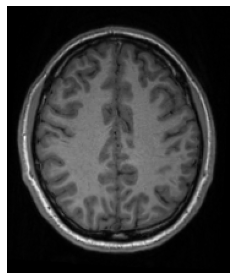

In [ ]:
sliceNumber = 110
plt.imshow(np.rot90(img_array[:, :, sliceNumber]), origin="upper", cmap="gray")
plt.axis('off')
plt.tight_layout()

Histograms for this slice

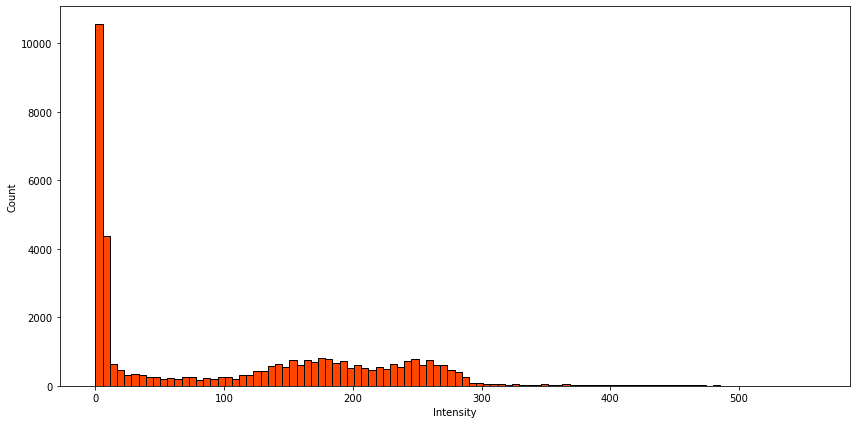

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(np.concatenate(img_array[:, :, sliceNumber]), bins=100, facecolor='orangered', edgecolor='black')
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.tight_layout()

Density plots for multiple slices. Notice that although the plots are generally similar, particularly in that they contain a lot of zeroes (i.e., background pixels), devising a general threshold to distinguish other the intensities in GM, WM and CSF  would not be possible.

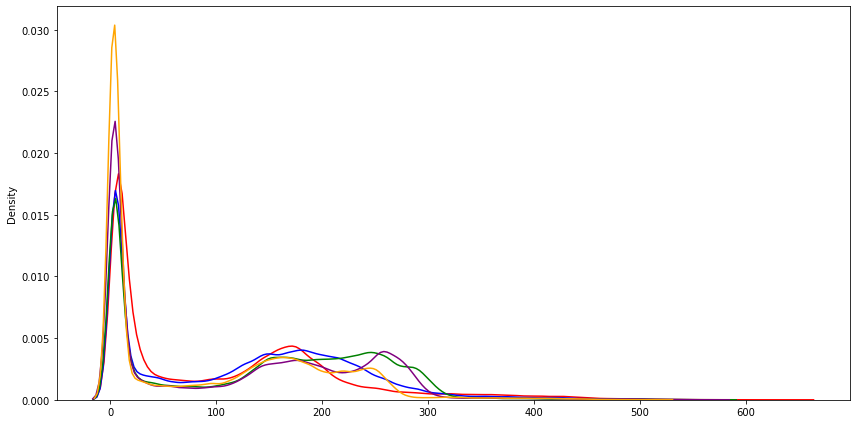

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(np.concatenate(img_array[:, :, 8]), color = 'red', bw_method=0.05)
sns.kdeplot(np.concatenate(img_array[:, :, 50]), color = 'blue', bw_method=0.05)
sns.kdeplot(np.concatenate(img_array[:, :, 75]), color = 'green', bw_method=0.05)
sns.kdeplot(np.concatenate(img_array[:, :, 105]), color = 'purple', bw_method=0.05)
sns.kdeplot(np.concatenate(img_array[:, :, 120]), color = 'orange', bw_method=0.05)
plt.tight_layout()

###Function for plotting multiple slices

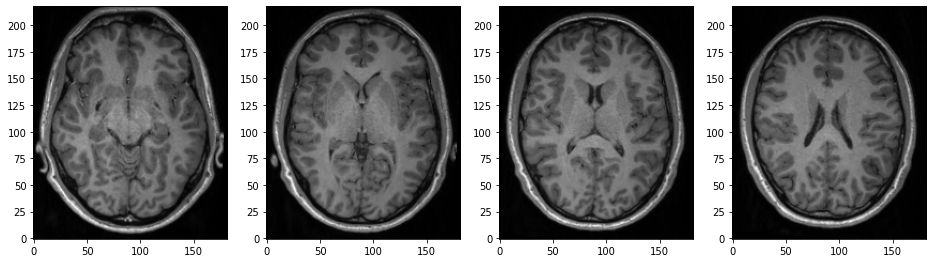

In [ ]:
def plot_slices(slices):
  fig, axes = plt.subplots(1, len(slices), figsize=(16,10))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_1 = img_array[:, :, 65]
slice_2 = img_array[:, :, 75]
slice_3 = img_array[:, :, 85]
slice_4 = img_array[:, :, 95]
plot_slices([slice_1, slice_2,slice_3,slice_4])


##Save slice as PNG image file

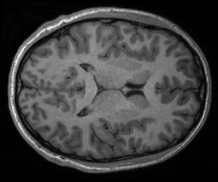

In [ ]:
sliceNumber=85
save_file(img_array[:, :, sliceNumber] * 255, "slice_"+str(sliceNumber)+".png")
display(Image("slice_"+str(sliceNumber)+".png"))

## Select a slice and run the segmentation
Try with and without anatomical priors. Remember this is just in 2D, so be mindful of which slice you select.
*You'll need to shave off 1 row in the x and y dimensions to fit this brain to the priors. This can be done by indexing the array.*

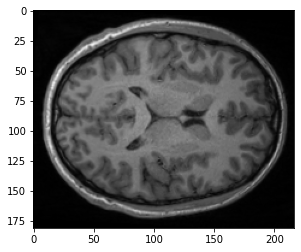

In [ ]:
img_array2 = img_array[0:181,0:217,1:182]
plt.imshow(img_array2[:, :, sliceNumber], cmap="gray")
slice = img_array2[:,:,sliceNumber]

Check the dimensions are now correct

In [ ]:
slice.shape

(181, 217)

**Set parameters**<br>
Re-run prior to each EM

In [ ]:
# Select input data
imgData = slice

# Parameters
didNotConverge = 1
iteration = 0
maxIterations = 20
numClass = 4
beta = 2
logLik = int(-10e8)
oldLogLik = int(-10e8)
tolerance = 200

# Initialise mean and variances
mean = np.random.rand(numClass,1)*256;
var = (np.random.rand(numClass,1)*10)+200;

# Allocate space for the posteriors
classProb = np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
classProbSum = np.ndarray([np.size(imgData,0),np.size(imgData,1)])

# Allocate space for the priors
classPrior=np.ndarray([np.size(imgData,0),np.size(imgData,1),4])
classPrior[:, :, 0] = GM_Prior/255
classPrior[:, :, 1] = WM_Prior/255
classPrior[:, :, 2] = CSF_Prior/255
classPrior[:, :, 3] = Other_Prior/255

for classIndex in range(0, numClass):
    pik = classPrior[:, :, classIndex]
    mean[classIndex] = np.sum(pik * imgData) / np.sum(pik)
    var[classIndex] = np.sum(pik * ((imgData - mean[classIndex]) ** 2)) / np.sum(pik)

# Define MRF array to match image dimensions
MRF=np.ndarray([np.size(imgData,0),np.size(imgData,1),numClass])
MRF[:,:,:]=1

**Run EM**

In [ ]:
# Iterative process
while didNotConverge:
    iteration=iteration+1

    # Expectation
    classProbSum[:, :] = 0;
    for classIndex in range(0, numClass):
        gaussPdf = (1/np.sqrt(var[classIndex]*2*np.pi))*np.exp(-0.5* (imgData-mean[classIndex])**2/var[classIndex])
        classProb[:, :, classIndex] = (gaussPdf+0.0000001)*classPrior[:, :, classIndex]*MRF[:,:,classIndex]
        classProbSum[:, :] = classProbSum[:, :]+classProb[:, :, classIndex]

    # Normalise posterior
    for classIndex in range(0, numClass):
        classProb[:, :, classIndex] = classProb[:, :, classIndex] /classProbSum[:, :]

    # Maximization
    print("Iteration #"+str(iteration))
    for classIndex in range(0, numClass):
        pik = classProb[:, :, classIndex]
        mean[classIndex] = np.sum(pik*imgData) / np.sum(pik)
        var[classIndex] = np.sum(pik*((imgData - mean[classIndex])**2)) / np.sum(pik)
        MRF[:,:,classIndex] = np.exp(-beta * Umrf(classProb,classIndex))
        print("Class index "+ str(classIndex) + ": mean = "+str(mean[classIndex]) + ", variance = " + str(var[classIndex]))

    # Calculate log likelihood
    oldLogLik = logLik
    logLik = np.sum(np.log(classProbSum))
    diffLogLik = oldLogLik - logLik
    print("Loglikelihood change = " + str(diffLogLik))

    if abs(diffLogLik)<=tolerance:
      didNotConverge=0
      print("Converged after " + str(iteration) + " iterations")

    if iteration>=maxIterations:
        didNotConverge=0
        print("Reached "+ str(maxIterations) + " iterations (the maximum) and did not coverge")

Iteration #1
Class index 0: mean = [185.55750665], variance = [2620.82964946]
Class index 1: mean = [236.1530151], variance = [1998.00610812]
Class index 2: mean = [179.0899803], variance = [4921.29504629]
Class index 3: mean = [64.55305914], variance = [10051.107051]
Loglikelihood change = -999774894.5301503
Iteration #2
Class index 0: mean = [175.99165076], variance = [1818.08615682]
Class index 1: mean = [242.69964027], variance = [1688.8664436]
Class index 2: mean = [165.12820791], variance = [4007.54843693]
Class index 3: mean = [68.65780298], variance = [10439.99958816]
Loglikelihood change = 61722.39448586712
Iteration #3
Class index 0: mean = [173.88424219], variance = [1641.39773352]
Class index 1: mean = [243.90337553], variance = [1631.40076782]
Class index 2: mean = [165.2763731], variance = [4136.83758629]
Class index 3: mean = [68.86301888], variance = [10438.78475808]
Loglikelihood change = -36080.96218733268
Iteration #4
Class index 0: mean = [172.94237281], variance = 

Save images

In [ ]:
for classIndex in range(0, numClass):
    print("Saving "+"slice_"+str(sliceNumber)+"_seg"+str(classIndex)+".png")
    save_file(classProb[ : ,: ,classIndex] * 255, "slice_"+str(sliceNumber)+"_seg"+str(classIndex)+".png")

Saving slice_85_seg0.png
Saving slice_85_seg1.png
Saving slice_85_seg2.png
Saving slice_85_seg3.png


Display images

slice_85_seg3.png


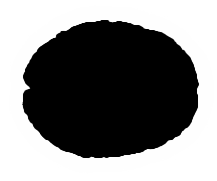

slice_85_seg1.png


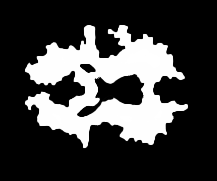

slice_85_seg0.png


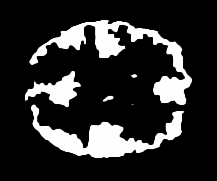

slice_85_seg2.png


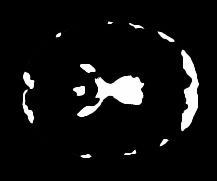

In [ ]:
import glob
for slice_seg in glob.glob('slice_'+str(sliceNumber)+'*seg*.png'):
    print(str(slice_seg))
    display(Image(slice_seg))